In [1]:
# Import libraries

import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
# Download dataset directly from Kaggle
!kaggle datasets download -d fakhrealam9537/leaf-disease-segmentation-dataset

In [3]:
# Unzip dataset
!unzip -q leaf-disease-segmentation-dataset.zip

In [4]:
# Initial directiories for images and masks
image_source_dir = "/content/aug_data/aug_data/images"
mask_source_dir = "/content/aug_data/aug_data/masks"

# Destination directories for train and val
train_image_dir = "/content/train_images"
train_mask_dir = "/content/train_masks"
val_image_dir = "/content/val_images"
val_mask_dir = "/content/val_masks"
test_image_dir = "/content/test_images"
test_mask_dir = "/content/test_masks"

# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)


# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
# Proportions: train_size = 0.75, val_size = 0.1, test_size = 0.15
validation_split = 0.1
test_split = 0.15

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_test_samples = int(len(image_files) * test_split)
num_train_samples = len(image_files)-num_validation_samples - num_test_samples
print(f'num train samples: {num_train_samples}')
print(f'num validation samples: {num_validation_samples}')
print(f'num test samples: {num_test_samples}')
# Randomly shuffle the list of files
random.seed(a=22)
random.shuffle(image_files)

# Move files to train and val directories
for i, image_file in enumerate(image_files[:num_train_samples]):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
    shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))

for i, image_file in enumerate(image_files[num_train_samples:(num_train_samples + num_validation_samples)]):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    shutil.copy(source_image_path, os.path.join(val_image_dir, image_file))
    shutil.copy(source_mask_path, os.path.join(val_mask_dir, source_mask_file))

for i, image_file in enumerate(image_files[(num_train_samples + num_validation_samples):]):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))
    shutil.copy(source_mask_path, os.path.join(test_mask_dir, source_mask_file))

print("Data separation complete.")

num train samples: 2205
num validation samples: 294
num test samples: 441
Data separation complete.


In [5]:
print(len(os.listdir(train_image_dir)), len(os.listdir(val_image_dir)), len(os.listdir(test_image_dir)))

2205 294 441


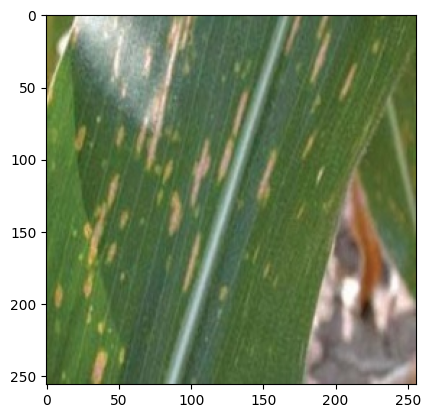

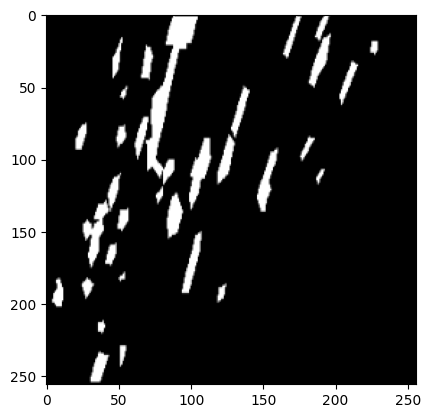

--------------------------------------------------


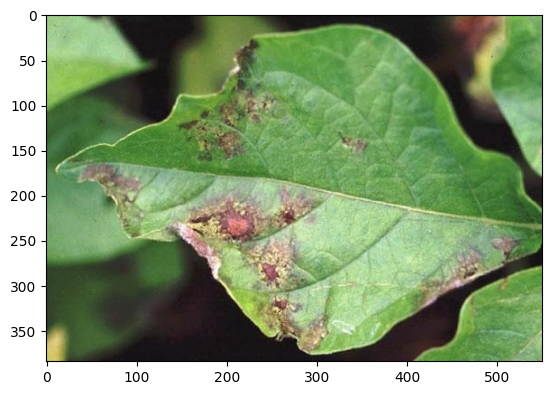

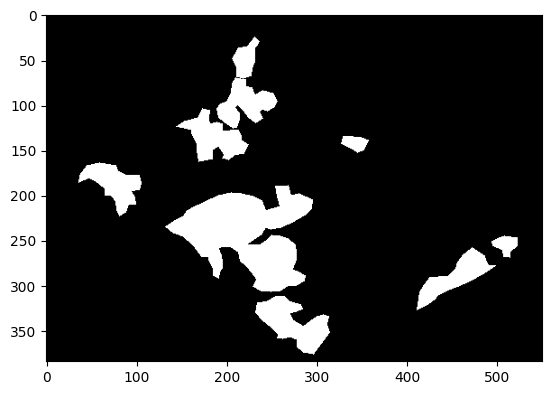

--------------------------------------------------


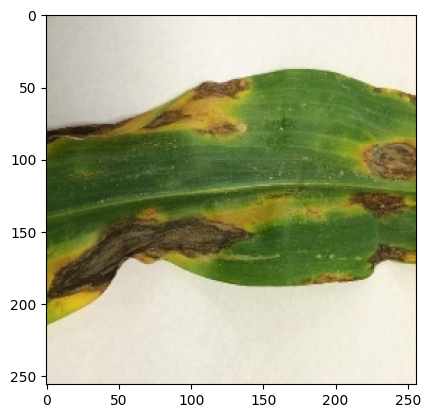

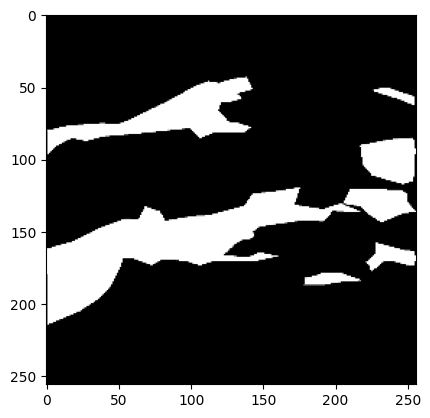

--------------------------------------------------


In [10]:
def show_images(loops: int=1) -> None:
    '''
    shows samples (images and masks) from train dataset

    Parameters:
    -----------
        loops (int):
            number of samples to show
    '''
    for i in range(loops):
        img_path = os.path.join(train_image_dir, image_files[i])
        source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
        mask_path = os.path.join(train_mask_dir, source_mask_file)
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        plt.imshow(img)
        plt.show()
        plt.imshow(mask, cmap='gray')
        plt.show()
        print("-"*50)

show_images(3)

In [ ]:
!pip install -q datasets

In [12]:
from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict

In [13]:
def create_dataset_object(mode: str) -> Dataset:
  '''
  creates an instance of HuggingFace Dataset class

  Parameters:
  -----------
      mode (str):
          part of the whole dataset (train, val or test)

  Return:
  -------
      dataset (Dataset):
          an instance of HuggingFace Dataset class
  '''
  dataset_image = load_dataset("imagefolder", data_dir=f'/content/{mode}_images')
  dataset_mask = load_dataset("imagefolder", data_dir=f'/content/{mode}_masks')
  dataset = Dataset.from_dict({'image': dataset_image['train']['image'], 'mask': dataset_mask['train']['image']})
  return dataset


In [ ]:
datasets_dict = {}
for mode in ['train', 'val', 'test']:
    datasets_dict[mode] = create_dataset_object(mode)

In [15]:
datasets_dict = DatasetDict(datasets_dict)

In [ ]:
import huggingface_hub

# log in to HuggingFace
huggingface_hub.login()

In [ ]:
# Push DatasetDict object to hub
datasets_dict.push_to_hub('Mauregato/leaf_disease_segmentation')